In [92]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re
import math
import time
import timeit

import sounddevice as sd
from scipy.io import wavfile

In [93]:
sd.query_devices()
# sd.default.device = 3

> 0 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Air Speakers, Core Audio (0 in, 2 out)
  2 ZoomAudioDevice, Core Audio (2 in, 2 out)

### Function to create file

In [94]:
def midi_to_timeseries(midiPath):
    """ Function that converts .txt file with midi events* to a list and returns all note on events.
    
    Args:
        midiPath: file path - .txt file with all note and pedal events of form [t,event,note/pedal,vel]
    
    Returns:
        time_notes: list of the form[[t,note,vel],[t,note,vel],[t,note,vel],...]
    
    """

    #    MIDI EVENT TYPES
    #    0x80 (hex)      128 (decimal)    Note Off
    #    0x90 (hex)      144 (decimal)    Note On
    #    0xB0 (hex)      176 (decimal)    Continuous Controller
    
    time_notes = []
    uniqueTypes = [128,144,176] 
            
    with open(midiPath) as midi_events:
        for line in midi_events:
            processedLine = line.split(" ")
    
            processedLine[0] = int(processedLine[0]) # processedLine[0] is timestamp
            processedLine[1] = int(processedLine[1], 16) # processedLine[1] is event type
            processedLine[2] = int(processedLine[2], 16) # processedLine[2] is note
            processedLine[3] = int(processedLine[3],16) # processedLine[3] is velocity

            if processedLine[1] not in uniqueTypes:
                print("unexpected event type got! ", processedLine[1])

            if processedLine[1] == 144:
                time_notes.append([processedLine[0], processedLine[2], processedLine[3]])
                
    return time_notes

### Function to read .wav file

In [95]:
def read_audio(file):
    """ Function that reads .wav file of midi recording and saves it to a global variable
    Args:
        file: .txt file with midi notes
    """
    
    global samplerate, piano_audio
    samplerate, piano_audio = wavfile.read(file)

read_audio('Audio.wav')

/var/folders/f5/4s_l2s456y985n42_18zrt_00000gn/T/ipykernel_14663/2785934704.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, piano_audio = wavfile.read(file)


### Functions to deal with notes as integers vs names

In [96]:
def int_to_note(i):
    """ Function that converts note from integer to name
    Args:
        i: integer value corresponding to note
    Returns:
        note: note name, eg. "C4" 
    """
    
    # convert integer to note
    notes = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    return notes[i%12] + str(i//12 - 1)

def note_to_int(note):
    """ Function that converts note from name to integer
    Args:
        note: note name, eg. "C4"
    Returns:
        i: integer value corresponding to note
    """
    
    # convert integer to note
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    note = temp.match(note).groups()
    notes = {'C':0,'C#/Db':1,'C#':1,'Db':1,'D':2,'D#/Eb':3,'D#':3,'Eb':3,'E':4,'F':5,'F#/Gb':6,'F#':6,'Gb':6,'G':7,'G#/Ab':8,'Ab':8,'G#':8,'A':9,'A#/Bb':10,'A#':10,'Bb':10,'B':11}
    return notes[note[0]] + 12*(int(note[1])+1)


### Functions to help judge quality of match

In [97]:
def predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, curr_time,pred_time=100,sound=False):
    """ Function that predicts the next 100 ms given a match
    Args:
        notes: 
        source_id_start: 
        source_id_end: 
        target_id_start: 
        target_id_end: 
        curr_time: 
        
    Returns:
        pred: predicted notes for 100ms, [[predTime1, note1, vel1], [predTime2, note2, vel2],...]
    """
    
    # predicting pred_time(100ms) of music
    time_ratio = (notes[target_id_start][0]-notes[target_id_end][0])/(notes[source_id_start][0]-notes[source_id_end][0])
    last_matching_note_target=0
    for event1 in range(source_id_start,source_id_end,-1):
        for event2 in range(target_id_start,target_id_end,-1):
            s = note_similarity(notes[event1],notes[event2],time_ratio)
            if s > 0:
                last_matching_note_target = event2
                break
        if last_matching_note_target:
            break
    
    target_time = notes[last_matching_note_target][0]
    time = target_time
    predicted = [target_id_start]
    i = target_id_start + 10
    while time <= target_time + pred_time:
        if notes[i][0] < time:
            predicted.append(i)
            i += 1
        time += 10
    predicted.append(i)
    
        
    if(sound):
        play_match(notes[source_id_start][0],notes[source_id_end][0],notes[predicted[-1]][0],notes[predicted[0]][0],pausebetween=False)
        
    return predicted
    
def display_match(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, sourceStart, targetStart):
    """ Function that displays the snippets if they match.
    Args:
        notes: note name, eg. "C4"
        source_start: 
        source_end: 
        target_start: 
        target_end: 
        score: 
        sourceStart: 
        targetStart: 
    """
    
    print("Score: ", score)
    print("Source({st}):  Target({tt}): ".format(st=source_id_end, tt=target_id_end))
    for i in range(min(source_id_start-source_id_end, target_id_start-target_id_end)):
        print(notes[i+source_id_end][0]-sourceStart, int_to_note(notes[i+source_id_end][1]), end=", ")
        print(notes[i+target_id_end][0]-targetStart, int_to_note(notes[i+target_id_end][1]))
    for i in range(target_id_start-target_id_end, source_id_start-source_id_end):
        print(notes[i+source_id_end][0]-sourceStart, int_to_note(notes[i+source_id_end][1]), end=", \n")
    for i in range(source_id_start-source_id_end, target_id_start-target_id_end):
        print("        ,",notes[i+target_id_end][0]-targetStart, int_to_note(notes[i+target_id_end][1]))
        
    print("  Next notes: ")
    for i in range(5):
        print(notes[i+source_id_start][0]-sourceStart,int_to_note(notes[i+source_id_start][1]), end=", ")
        print(notes[i+target_id_start][0]-targetStart,int_to_note(notes[i+target_id_start][1]))
        
    print()
        
def play_match(source_start, source_end, target_start, target_end, pausebetween=False):
    """ Function that plays portion of audio file corresponding to each sequence of a match
    Args:
        source_start: 
        source_end: 
        target_start: 
        target_end: 
    """
    
    global piano_audio
    ss = source_start * samplerate // 1000
    se = source_end * samplerate // 1000
    te = target_end * samplerate // 1000
    ts = target_start * samplerate // 1000
    #Source
    sd.play(piano_audio[se:ss], samplerate, blocking = True)
    if pausebetween:
        time.sleep(1)
    #Target
    sd.play(piano_audio[te:ts], samplerate, blocking = True)
    if pausebetween:
        time.sleep(1)
        
def display_snippet_plot(notes, source_start, source_end, target_start, target_end, score, sourceStart, targetStart):
    plt.figure(figsize = (10,5))
    lenSource = source_start-source_end
    lenTarget = target_start-target_end
    timeStampSourceEnd = notes[(lenSource - 1)+source_end][0]-sourceStart
    timeStampTargetEnd = notes[(lenTarget - 1)+target_end][0]-targetStart

    if timeStampSourceEnd >= timeStampTargetEnd:
        xmax = timeStampSourceEnd
    else:
        xmax = timeStampTargetEnd

#     plt.xlim(0,xmax)
    plt.xlabel("Relative Snippet Time (in MS)")
    # yscale = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    # plt.yticks(range(0,len(yscale)),yscale)
    plt.ylabel("Note (Integer Representation)")
    title = "Snippet Plot:" + ", Source @ " + str(notes[source_end][0]) + " ms, Target @ " + str(notes[target_end][0]) + " ms, Score: " + str(round(score,4))
    plt.title(title)
    plt.locator_params(axis="both", integer=True, tight=True)

    sourceX = []
    sourceY = []
    targetX = []
    targetY = []
    for i in range(min(source_start-source_end, target_start-target_end)):
        sourceX.append(notes[i+source_end][0]-sourceStart)
        sourceY.append((notes[i+source_end][1]))
        targetX.append(notes[i+target_end][0]-targetStart)
        targetY.append((notes[i+target_end][1]))
    for i in range(target_start-target_end, source_start-source_end):
        sourceX.append(notes[i+source_end][0]-sourceStart)
        sourceY.append((notes[i+source_end][1]))
    for i in range(source_start-source_end, target_start-target_end):
        targetX.append(notes[i+target_end][0]-targetStart)
        targetY.append((notes[i+target_end][1]))

    plt.scatter(sourceX, sourceY, label="Source",marker='*')
    plt.scatter(targetX, targetY, label="Target",marker='.')
    plt.legend()
    plt.show()

def display_snippet_plot_2(sequence1,sequence2,source_start,target_start,score):
    plt.figure(figsize = (10,5))

#     plt.xlim(0,xmax)
    plt.xlabel("Relative Snippet Time (in MS)")
    # yscale = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    # plt.yticks(range(0,len(yscale)),yscale)
    plt.ylabel("Note (Integer Representation)")
    plt.locator_params(axis="both", integer=True, tight=True)

    sourceX = [] # x axis - source timestamp in ms
    sourceY = [] # y axis - note integer repr for source
    targetX = []
    targetY = []
    for i in range(len(sequence1)):
        sourceX.append(sequence1[i][0])
        sourceY.append(sequence1[i][1])

    for i in range(len(sequence2)):
        targetX.append(sequence2[i][0])
        targetY.append(sequence2[i][1])

    title = "Snippet Plot:" + ", Source @ " + str(source_start) + " ms, Target @ " + \
        str(target_start) + " ms, Score: " + str(score) + ", Length (ms): "+ str(sourceX[-1]-sourceX[0])
    plt.title(title)
    plt.scatter(sourceX, sourceY, label="Source",marker='*')
    plt.scatter(targetX, targetY, label="Target",marker='.')
    plt.legend()
    plt.show()
    
    
    

### Functions to calculate similarity

In [98]:
def two_way_similarity(tf1, tf2, disp = False):
    return max(musical_similarity(tf1,tf2,disp),musical_similarity(tf2,tf1,disp))

def musical_similarity(tf1, tf2, disp = False):
    """ Function that calculates similarity score between 2 snippets 
        eg [[-17,60],[-100,62],[-101,64],[-300,60]] and [[-20,60],[-50,61],[-101,64],[-102,62],[-307,60]]
    
    Args:
        tf1: first snippet [[t,note,vel],[t,note,vel],[t,note,vel],...]
        tf2: second snippet [[t,note,vel],[t,note,vel],[t,note,vel],...]
    
    Returns:
        score: similarity - integer between 0 to 1
    
    """
    # updating time stamps wrt first note for tf1
    sequence1 = []
    first1 = tf1[0] # Timestamp of first note
    for el in tf1: # Save time delta of each note in sequence (relative to first note)
        sequence1.append([el[0]-first1[0],el[1]])
    
    seq_1_time_del = (tf1[-1][0] - tf1[0][0]) * 1.0
    
    # updating time stamps wrt first note for tf2
    sequence2 = []
    first2 = tf2[0]
    for el in tf2:
        if el[1] == first1[1]:
            first2 = el
            break
    for el in tf2:
        sequence2.append([el[0]-first2[0],el[1]])
    
    seq_2_time_del = tf2[-1][0] - tf2[0][0]
    
    time_ratio = seq_2_time_del / seq_1_time_del
    
    # Calculating score array by comparing every note from each sequence and taking the best match
    score = []
    n = len(sequence1)
    matched_targets = [0 for i in range(n)]
    for event1 in range(n): # Starting from middle towards end then twoards beginning
        max_score = 0 # score for best match with event1
        max_el = -1 # note index of best match
        for event2 in range(len(sequence2)):
            s = note_similarity(sequence1[event1],sequence2[event2],time_ratio*(event2+1))
            if s > max_score:
                max_score = s
                max_el = event2
                
        # If we get a non-zero similarity score, we assume that the
        # two notes "match", and remove them from the potential match
        # pool
        if max_score != 0: # if match found
            score.append(max_score)
            matched_targets[event1] = sequence2[max_el]
#             sequence1[event1] = [] # setting to empty because a match for this note has already been found
#             sequence2[max_el] = []
                
    
    # For every pair of notes in both sequences, if a match was not found, add a zero score
    for i in range((len(sequence1) + len(sequence2) - (2*len(score)))):
        score.append(0)
       
    # Similarity of the two sequences is the mean of the note similarity scores
    score = np.mean(score)
    
    # including length in score, if at least 5 notes
    if len(tf1)>5:
        score += score * seq_1_time_del/100000 # 10 seconds yield 10% increase
        
#     if score>1:
#         score = 1
    
    if disp and score>0.7:
        print("Scores:",score)
        print("Sequence1: ",sequence1)
        print("Sequence2: ",sequence2)
        print("Matched vals: ",matched_targets)
        display_snippet_plot_2(sequence1,sequence2,tf1[0][0],tf2[0][0],score)
    
    return score
     
def note_similarity(note1,note2,ratio):
    """ Function that calculates similarity score between 2 notes - depending on note value and time
    
    Args:
        note1: first note to compare [t,note,vel]
        note2: second note to compare [t,note,vel]
    
    Returns:
        score: similarity - integer between 0 to 1
    
    """
    # score is linear with time difference between notes
    
    min_dist = 50 * ratio # acceptable time difference for same note
    
    if (not note1) or (not note2):
        return 0
    if note1 == note2: # exact match!
        return 1
    if note1[1] != note2[1]: # different notes
        return 0
    
    # check if acceptable match wrt time - score is linear with time stamp difference
    time_diff = abs(note1[0] - note2[0])
    if  time_diff < min_dist:
        return 1 - time_diff/min_dist
    else:
        return 0
    

### Helper Functions

In [99]:
def time_to_index(notes, timestamp):
    for i in range(len(notes)):
        if notes[i][0] > timestamp:
            return i
        
def index_to_time(notes, index):
    return notes[index][0]

def index_to_sequence(notes, ids): # assume start>end & not include start for convention
    start_id, end_id = ids
    sequence = []
    for i in range(end_id,start_id):
        sequence.appaned(notes[i])
    return sequence

def time_to_sequence(notes, times): # assume start>end & not include start for convention
    start, end = times
    i = time_to_index(notes, end)
    sequence = []
    while i < len(notes):
        if notes[i][0]>=start:
            break
        sequence.append(notes[i])
        i += 1
    return sequence


In [100]:
midiPath = '../midi-recordings/ladispute.txt'
# midiPath = '../midi-recordings/2_prelude.txt'
notes = midi_to_timeseries(midiPath)

0.7648436637141028


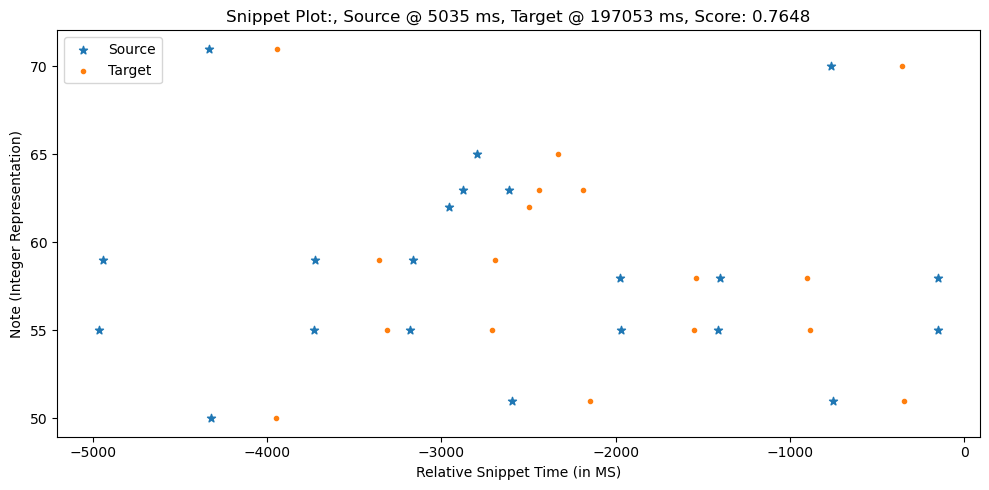

0.8417852967978405


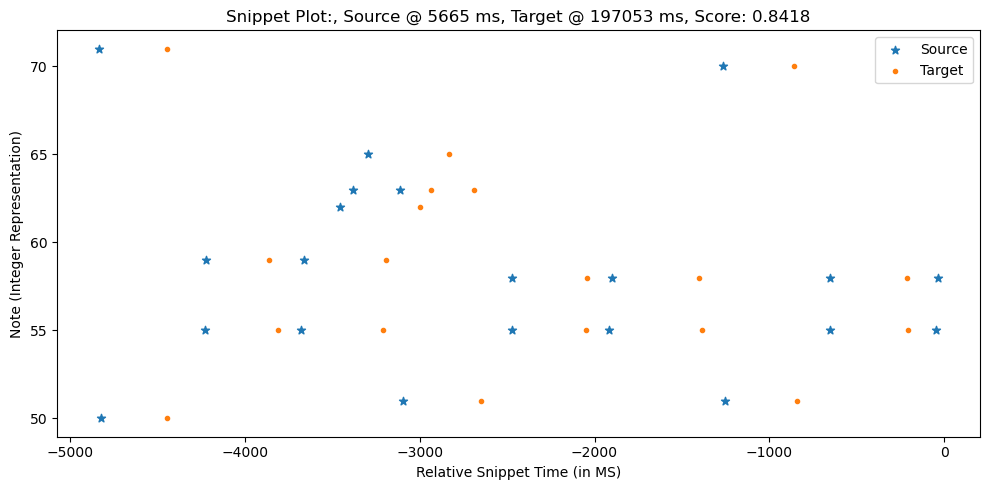

0.8145505320209796


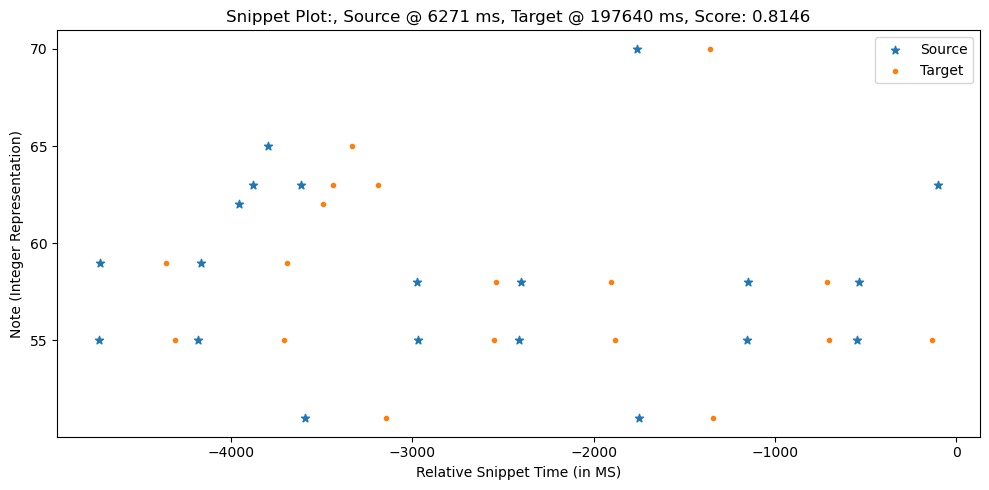

0.9141772477924021


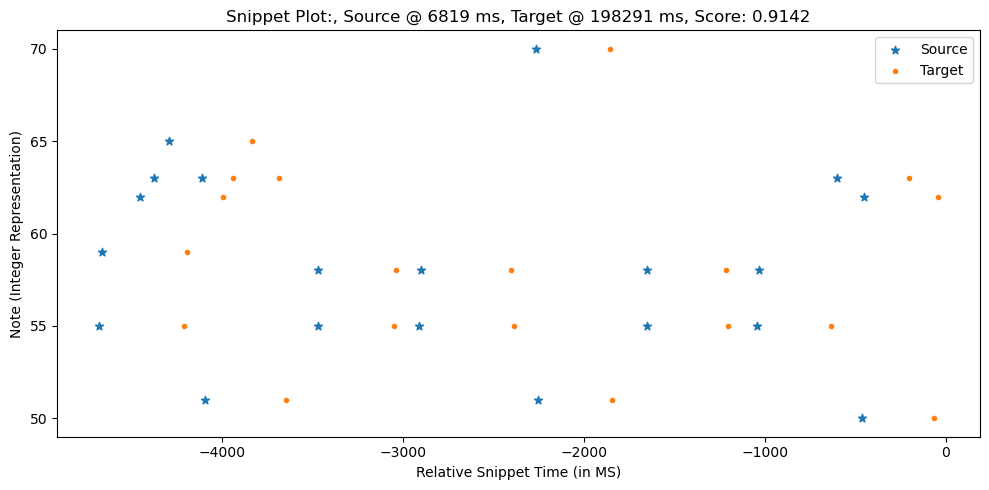

0.8209019228367221


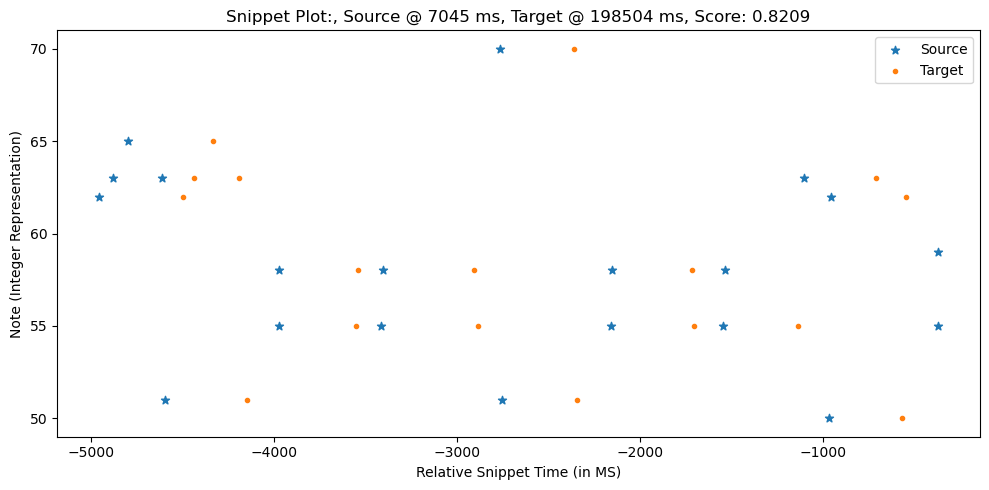

0.7627059153932587


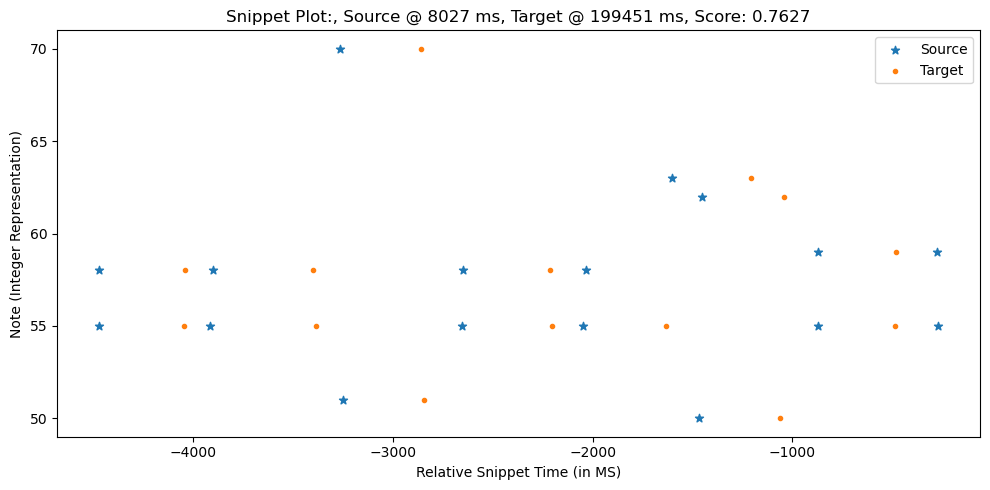

0.8352529804008911


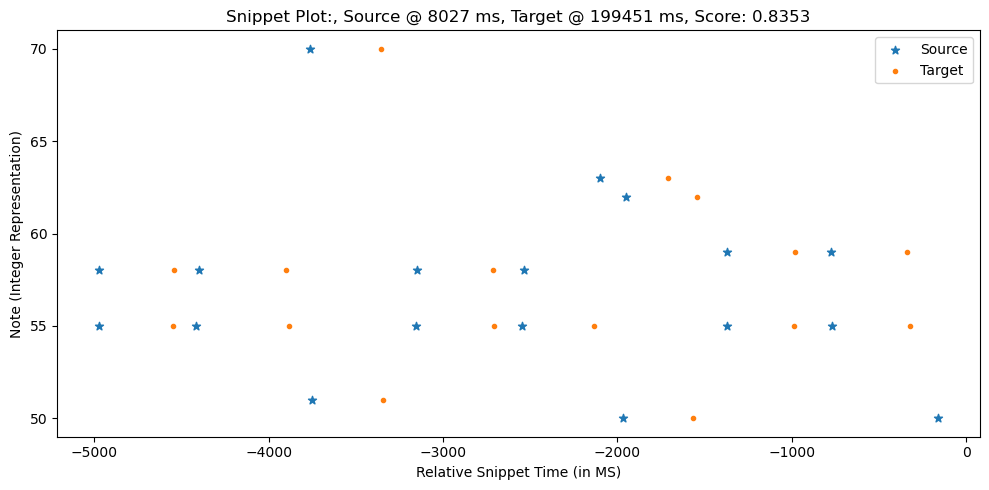

0.6914311208457478


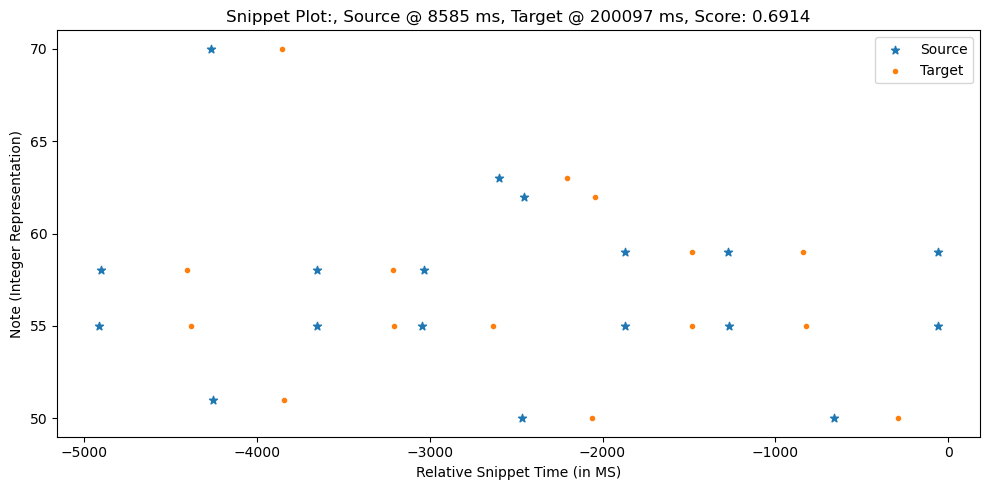

0.9245778740911172


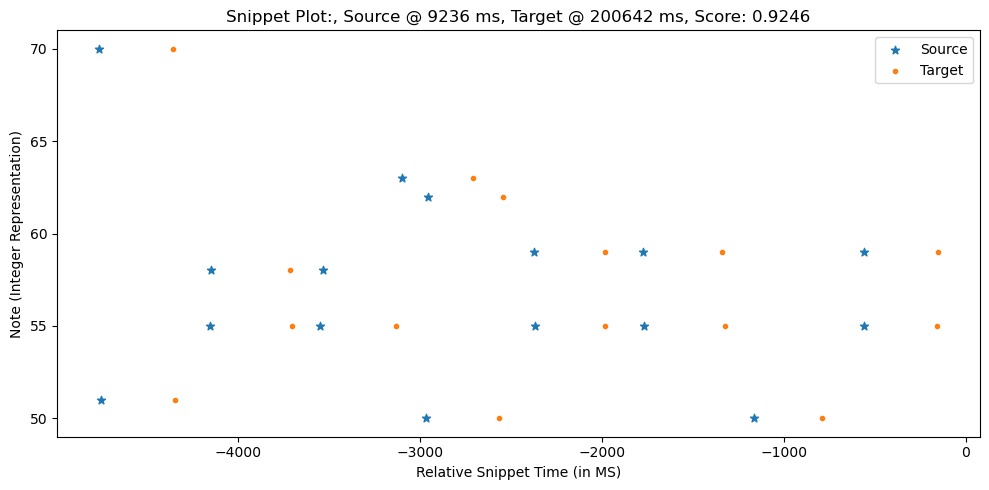

0.8284842792300019


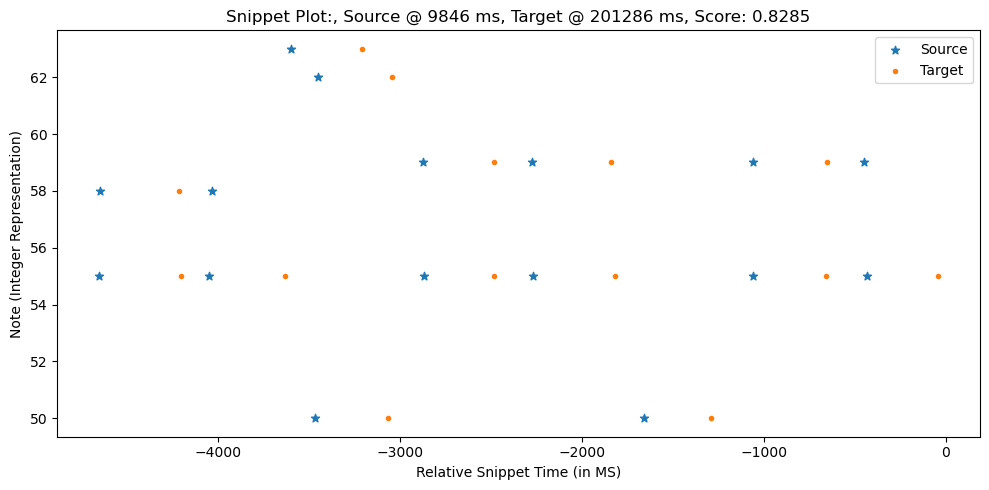

In [101]:
for x in range(5000,10000,500):
#     x = 0
    t1 = [5000+x,0+x] # timestamps in ms
    t2 = [196000+x,191400+x]
#     t2 = [418000+x,413000+x]
#     t2 = [587000+x,587000+x]

    tf1 = time_to_sequence(notes, t1)
    tf2 = time_to_sequence(notes, t2)

    score = max(musical_similarity(tf1,tf2,disp=False),musical_similarity(tf2,tf1,disp=False))
    print(score)
#     if score<0.8:
    display_snippet_plot(notes, time_to_index(notes,t1[0]),time_to_index(notes,t1[1]),time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), score, t1[0], t2[0])
#         play_match(t1[0],t1[1],t2[0],t2[1])
#         predict(notes, time_to_index(notes,t1[0]), time_to_index(notes,t1[1]), time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), tf1[-1][0],pred_time=100,sound=True)
#         time.sleep(2)

In [102]:
def calculate_similarity_time(notes, source_id, currTime, max_matches=None, skip = 100, disp=False):
    """ Function that calls musical similarity on targets generated for a source_id.
        Target snips start at every 100 ms, and has same time length as source.
    
    Args:
        notes: list of all notes from a recording [[t,note,vel],[t,note,vel],[t,note,vel],...]
        source_id: indices of note array corresponding to current time snippet (source_id_start>source_id_end) 
                   [source_id_start, source_id_end]
        currTime: time stamp at which we are searching for matches (ms)
        max_matches: optional param to state how many matches to stop after
        disp: boolean whether to print each match (defaults True)
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    calcstart = timeit.default_timer()
    matches = []
    last_id_end = 0 # track previous end index of target
    last_id_start = 0
    source_id_start, source_id_end = source_id
    source_end = notes[source_id_end][0] # start and end time stamps of source
    length_ms = currTime - source_end #in milliseconds
    count = 0 # counting num "good" matches
    
    for target_start in range(length_ms, currTime-20000, skip):
#         starttime = timeit.default_timer()
        target_end = target_start - length_ms # pick target_end by time length of course snip
        
        # finding new end index
        for i in range(last_id_end,len(notes)):
            if notes[i][0] >= target_end:
                target_id_end = i
                break
             
        # finding new start index
        for i in range(target_id_end,len(notes)):
            if notes[i][0] > target_start:
                target_id_start = i
                break
                
        if target_id_end > target_id_start-4:
            continue
#         if target_id_end == last_id_end and last_id_start == target_id_start:
#             continue
            
#         score = musical_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start])
        score = two_way_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start],disp=disp)
        if score:
            if score>0.7:
                count += 1
                # Dsiplaying matches > 0.7 if disp is True
                if disp:
                    display_match(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
#                     display_snippet_plot(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
                    play_match(currTime, source_end, target_start, target_end)
    #                 predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, currTime, target_start)
                    time.sleep(5)

            matches.append([currTime, target_start, score])
        
        if max_matches and count > max_matches:
            break
        last_id_end = target_id_end
        last_id_start = target_id_start
#         looptime = timeit.default_timer() - starttime
#         if looptime>0.05:
#             print("LoopTime:",looptime,"target&source:",currTime,target_start)
        
    calctime = timeit.default_timer() - calcstart
    global t_exec
    t_exec.append([currTime,calctime])
#     if calctime>1:
#         print("Time:",calctime,"for source:",currTime,"and length",length_ms,"ms",",score:",matches[:][2])
    
    return matches


In [103]:
def get_source_notes_index(notes, start_index, start_time, min_notes, max_notes, min_time):
    """ Function that ...
    
    Args:
        notes: list of all note arrays of lengths min_notes to max_notes snip[1][2][3][4]
               1 - length of snip, 2 - start index from notes, 3 - index of note in array, 4 - [t, note, vel]
        start_index: 
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)\
    
    Returns:
        source_id: 
    
    """
    for end_index in range(start_index-min_notes, start_index - max_notes - 1, -1):
        if start_time - notes[end_index][0] >= min_time:
            source_id = [start_index,end_index]
            return source_id
        
#     print("Error: Trying to access snippet length > max_notes",end=" ")
    return None

def get_source_notes(notes, start_time, min_notes, max_notes, min_time):
    """ Function that ...
    
    Args:
        snips: list of all note arrays of lengths min_notes to max_notes snip[1][2][3][4]
               1 - length of snip, 2 - start index from notes, 3 - index of note in array, 4 - [t, note, vel]
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)
        offset: used to find note snippets longer than min_length, integer, default=0
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    for i in range(len(notes)):
        if notes[i][0] > start_time:
            start_index = i
            break
    else:
        print("Error: Start time too large")
        return None
    
    if start_index<3:
        return None
    
    return get_source_notes_index(notes, start_index, start_time, min_notes, max_notes, min_time)

In [ ]:
midiPath = '../midi-recordings/ladispute.txt'
# midiPath = '../midi-recordings/2_prelude.txt'
notes = midi_to_timeseries(midiPath)

global t_exec
t_exec=[]

minNotes = 8
maxNotes = 60 # max length of snippet to be calculated
minTime = 1500 # min time in ms
# maxMatches = 30 # if more matches, increase snippet length
thresh = 0.7
start = 25000
skip = minTime
end = notes[-1][0]

# calculating similarity
# percentage_matches_thresh = 0
# percentage_matches_any = 0
sims_arr = []
sourceId = 1
index = 0
for i in range(start, end, minTime):
#     sims.append([])
    print("\r",end="")
    print("i:",i,end="   ")
    # only calculate on historical timestamps
    offset = 500
    count = notes[-1][0] + 1 # count number of relevant matches
#     max_matches = 30 # if more matches, increase size of snippet
    oldtime = minTime
    numSourceNotes = 0
    sourceTime = 0
    attempt = 1
#     while numSourceNotes < maxNotes:
    while sourceTime < 10000:
        sourceId = get_source_notes(notes, i, minNotes, maxNotes, oldtime+offset)
        if not sourceId:
#             print("Failed for source_id = ", sourceId, ", on attempt ", attempt,end=" ")
#             if offset>0:
#                 percentage_matches_any += 1
            break

        # num notes in source snippet
        numSourceNotes = (sourceId[0] - sourceId[1])
        # total time in ms in source snippet
        sourceTime = (notes[sourceId[0]][0] - notes[sourceId[1]][0])
        
        oldtime = notes[sourceId[0]][0] - notes[sourceId[1]][0]
        sim = calculate_similarity_time(notes, sourceId, i, disp=False)
        count = 0
        for match in sim:
            match.append(numSourceNotes)
            match.append(sourceTime)
            sims_arr.append(match)
            if match[2] > 0.9:
                count += 1
#         offset += 500
        attempt += 1

#     if sourceId and sim:
#         percentage_matches_any += 1
#         flag = True
#         for match in sim:
#             sims_arr.append(match)
#             if flag and match[2]>0.7:
#                 percentage_matches_thresh += 1
#                 flag = False

    index += 1


i: 92500   

In [85]:
## choosing only significant scores and storing the new data in sims_plot

sims_arr = np.array(sims_arr)
sims_thresh = sims_arr * (sims_arr>thresh) # considering a match if score greater than a threshold

simsDF = pd.DataFrame(data=sims_thresh, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])
simsDFall = pd.DataFrame(data=sims_arr, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])



<AxesSubplot:title={'center':'All matches >0.7, for \nMin Snippet Length=8 notes, Max notes=20'}, xlabel='source_timestamp', ylabel='target_timestamp'>

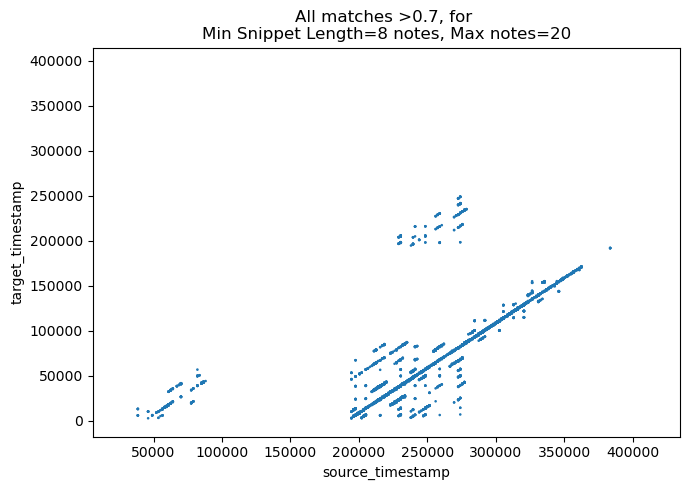

In [86]:
# plotting all mathes > threshold score

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Snippet Length=" + str(minNotes) + " notes, Max notes=" + str(maxNotes)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)




Percentage matches found: 55.53191489361702%


Percentage matches >0.7 found: 28.936170212765955%


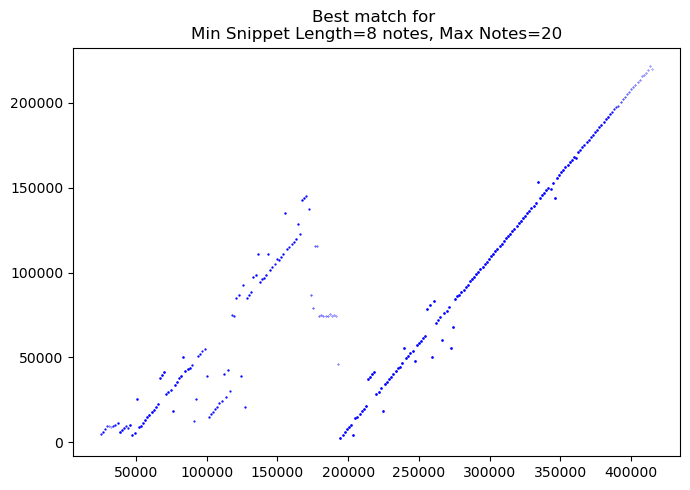

In [87]:
# Plotting best match only

percentage_matches_any = 0
percentage_matches_thresh = 0

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

total = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score']
    total += 1
    if y.any(): 
        y = y.idxmax()
        percentage_matches_any += 1
        if simsDFall['score'].loc[y] > thresh:
            percentage_matches_thresh += 1
    else:
#         print("No match for",x)
        continue
    plt.scatter(simsDFall['source_timestamp'].loc[y],simsDFall['target_timestamp'].loc[y],simsDFall['score'].loc[y],c='blue')
   
# gjnjn
percentage_matches_any /= total
percentage_matches_thresh /= total
print("\n\nPercentage matches found: ", percentage_matches_any*100,"%",sep="")
print("\n\nPercentage matches >",thresh," found: ", percentage_matches_thresh*100,"%",sep="")

plt.title("Best match for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.show()

209


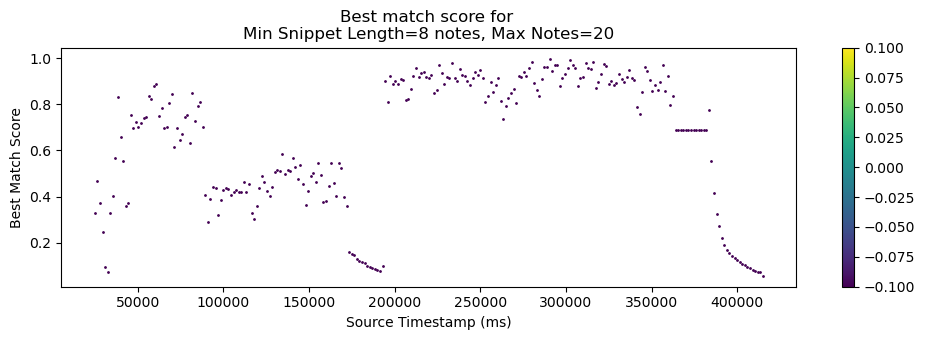

In [88]:
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,y,1,c=s,cmap='viridis') # need to include s (len of best match)
    
print(count)
plt.title("Best match score for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Score")
plt.show()

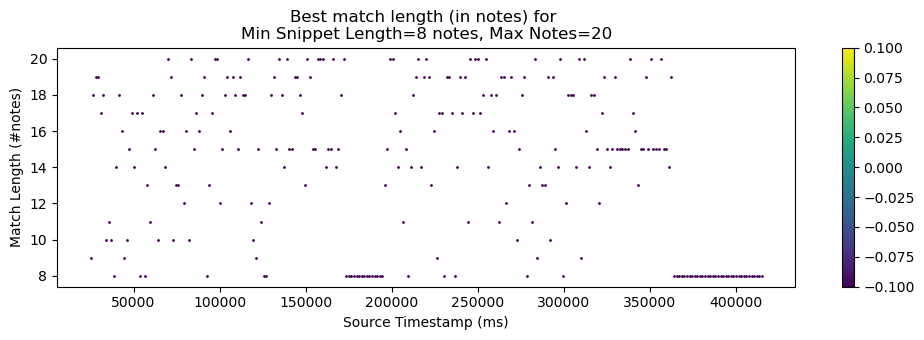

In [89]:
# Plotting note length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,s,1,c=y,cmap='viridis') # need to include s (len of best match)
    
# print(count)
plt.title("Best match length (in notes) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (#notes)")
plt.show()

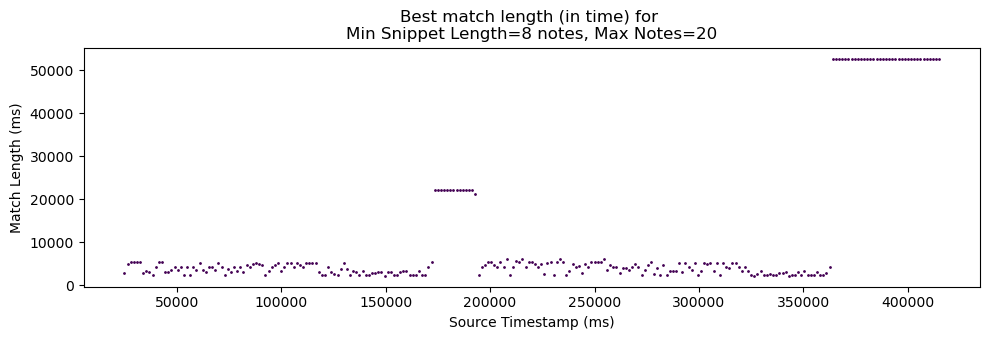

In [90]:
# Plotting time length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_time'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,s,1,c=y,cmap='viridis') # need to include s (len of best match)
    
# print(count)
plt.title("Best match length (in time) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (ms)")
plt.show()

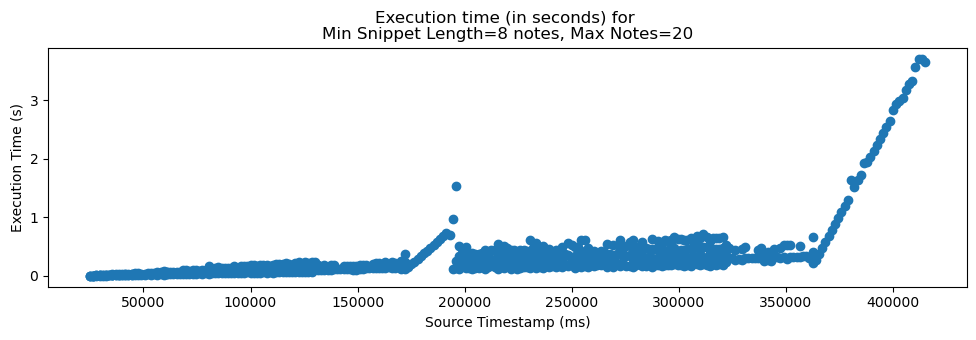

In [91]:
t_exec = np.array(t_exec)
plt.scatter(t_exec[:,0],t_exec[:,1])
plt.title("Execution time (in seconds) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Execution Time (s)")
plt.show()

In [28]:
## choosing only significant scores and storing the new data in sims_plot

sims_arr = np.array(sims_arr)
sims_thresh = sims_arr * (sims_arr>thresh) # considering a match if score greater than a threshold

simsDF = pd.DataFrame(data=sims_thresh, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])
simsDFall = pd.DataFrame(data=sims_arr, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])

## choosing only significant scores and storing the new data in sims_plot

sims_arr = np.array(sims_arr)
sims_thresh = sims_arr * (sims_arr>thresh) # considering a match if score greater than a threshold

simsDF = pd.DataFrame(data=sims_thresh, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])
simsDFall = pd.DataFrame(data=sims_arr, columns=['source_timestamp', 'target_timestamp','score','match_len','match_time'])

# plotting all mathes > threshold score

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Snippet Length=" + str(minNotes) + " notes, Max notes=" + str(maxNotes)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)

<AxesSubplot:title={'center':'All matches >0.7, for \nMin Snippet Length=8 notes, Max notes=60'}, xlabel='source_timestamp', ylabel='target_timestamp'>

# Plotting best match only

percentage_matches_any = 0
percentage_matches_thresh = 0

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

total = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score']
    total += 1
    if y.any(): 
        y = y.idxmax()
        percentage_matches_any += 1
        if simsDFall['score'].loc[y] > thresh:
            percentage_matches_thresh += 1
    else:
#         print("No match for",x)
        continue
    plt.scatter(simsDFall['source_timestamp'].loc[y],simsDFall['target_timestamp'].loc[y],simsDFall['score'].loc[y],c='blue')
   
# gjnjn
percentage_matches_any /= total
percentage_matches_thresh /= total
print("\n\nPercentage matches found: ", percentage_matches_any*100,"%",sep="")
print("\n\nPercentage matches >",thresh," found: ", percentage_matches_thresh*100,"%",sep="")

plt.title("Best match for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.show()


Percentage matches found: 83.5728952772074%


Percentage matches >0.7 found: 76.38603696098562%

Score
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,y,1,c=s,cmap='viridis') # need to include s (len of best match)
    
print(count)
plt.title("Best match score for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Score")
plt.show()


# Plotting note length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    plt.scatter(x,s,1,c=y,cmap='viridis') # need to include s (len of best match)
    
# print(count)
plt.title("Best match length (in notes) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (#notes)")
plt.show()



SyntaxError: invalid syntax (796303729.py, line 25)